# Kod

In [ ]:
#!/usr/bin/env bash

set -x

mpiexec  -machinefile ./same_host -np 2 ./timer.py | tee results/1_shm_host.csv
MPIR_CVAR_CH3_NOLOCAL=1 mpiexec  -machinefile ./same_host -np 2 ./timer.py | tee results/2_net_host.csv
MPIR_CVAR_CH3_NOLOCAL=1 mpiexec  -machinefile ./same_machine -np 2 ./timer.py | tee results/3_net_machine.csv
MPIR_CVAR_CH3_NOLOCAL=1 mpiexec -machinefile ./different_machine -np 2 ./timer.py | tee results/4_net_diff.csv

* same_host 
 - `vnode-03.dydaktyka.icsr.agh.edu.pl:2`
* same_machine 
 - `vnode-02.dydaktyka.icsr.agh.edu.pl:1`
 - `vnode-03.dydaktyka.icsr.agh.edu.pl:1`
* different_machine
 - `vnode-03.dydaktyka.icsr.agh.edu.pl:1`
 - `vnode-04.dydaktyka.icsr.agh.edu.pl:1`

In [ ]:
#!/usr/bin/env python2
import sys
import gc
import numpy as np
from mpi4py import MPI


def gen_lengths(max_len):
    x = 1
    while x < max_len:
        yield int(x)
        if x < 50:
            x += 5
        else:
            x *= 1.8

if __name__ == "__main__":
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()

    results = []
    iterations = 100

    for i in range(3):
        rst = []
        for payload_size in gen_lengths(max_len=(2**26)):

            payload_bytes = bytearray(payload_size)
            gc.collect()

            comm.Barrier()
            start_reg = MPI.Wtime()
            for _ in xrange(iterations):
                if rank == 0:
                    comm.send(payload_bytes, dest=1)
                elif rank == 1:
                    comm.recv(source=0)
            end_reg = MPI.Wtime()

            comm.Barrier()
            start_sync = MPI.Wtime()
            for _ in xrange(iterations):
                if rank == 0:
                    comm.ssend(payload_bytes, dest=1)
                elif rank == 1:
                    comm.recv(source=0)
            end_sync = MPI.Wtime()
            comm.Barrier()

            m_bit_per_second_reg = ((8 * payload_size * iterations)/(end_reg - start_reg)) / 10**6
            m_bit_per_second_sync = ((8 * payload_size * iterations)/(end_sync - start_sync)) / 10**6
            rst.append((payload_size, m_bit_per_second_reg, m_bit_per_second_sync))
        results.append(rst)
        
    if rank == 0:
        x = np.array(results)
        x = np.array(x.transpose().mean(axis=-1)).transpose()
        print 'size;bandwidth(reg);bandwidth(sync)'
        for r in x:
            print '%d;%f;%f' % (r[0], r[1], r[2])          

# Sprawozdanie

In [4]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd

In [5]:
%matplotlib inline

## Parametry
* Tryby komunikacji: standardowy i synchronizowany
* Każdy pomiar był przeprowadzany 3 razy, końcowy wynik to średnia
* Przepustowość: `(8 * payload_size * iterations)/(end - start)) / 10**6`, gdzie `iterations = 100`
* Payload: `payload = bytearray(payload_size)`, w rozmiarach od ***1 B*** do ***4 MB***

## Wpływ typu payloadu na przepustowość

In [24]:
import sys
length = 2**20
print(length)
print(sys.getsizeof("a"*length)+sys.getsizeof(""))
print(sys.getsizeof(bytearray(length)))

1048576
1048674
1048633


In [38]:
path = "results/str-vs-bytes-reg-shm.csv"
times = pd.read_csv(path, delimiter=';')
times.describe()

,size,bandwidth(str),bandwidth(bytes)
count,1.270000e+02,127.000000,127.000000
mean,3.506106e+05,10171.529396,1048.228346
std,8.756665e+05,9327.223621,859.172463
min,1.000000e+00,2.708187,0.000000
25%,1.060000e+02,446.745720,94.000000
50%,3.783000e+03,9050.955004,1219.000000
75%,1.345605e+05,18178.249245,1684.000000
max,4.770791e+06,28711.046326,3124.000000


Text(0.5, 0, 'Size [ B ]')

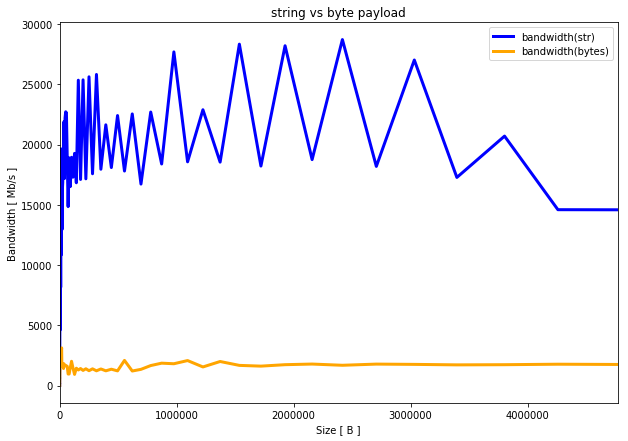

In [41]:
p = times.plot(x='size', title='string vs byte payload', figsize=(10,7), color=['blue', 'orange'], linewidth=3)
p.set_ylabel("Bandwidth [ Mb/s ]")
p.set_xlabel("Size [ B ]")

## Komunikacja przez pamięć współdzieloną

In [26]:
path = "results/1_shm_host.csv"
times = pd.read_csv(path, delimiter=';')
times.describe()

,size,bandwidth(reg),bandwidth(sync)
count,9.400000e+01,94.000000,94.000000
mean,3.177032e+05,1329.633063,1076.266418
std,7.799629e+05,1115.394473,835.789782
min,1.000000e+00,0.893633,0.748843
25%,1.310000e+02,114.022521,92.759692
50%,4.156000e+03,1690.001353,1438.330948
75%,1.309290e+05,1934.375769,1863.367764
max,4.119177e+06,3629.412577,2103.823049


![title](results/1_shm_host.png)

## Komunikacja przez sieć, ten sam host

In [34]:
path = "results/2_net_host.csv"
times = pd.read_csv(path, delimiter=';')
times.describe()

,size,bandwidth(reg),bandwidth(sync)
count,9.400000e+01,94.000000,94.000000
mean,3.177032e+05,1334.853260,1073.698576
std,7.799629e+05,1129.451473,830.348837
min,1.000000e+00,0.894058,0.765167
25%,1.310000e+02,114.650660,94.404673
50%,4.156000e+03,1684.974757,1431.911355
75%,1.309290e+05,1907.147222,1852.789143
max,4.119177e+06,3724.424303,2077.515625


![title](results/2_net_host.png)

## Komunikacja przez sieć, ta sama maszyna

In [42]:
path = "results/3_net_machine.csv"
times = pd.read_csv(path, delimiter=';')
times.describe()

,size,bandwidth(reg),bandwidth(sync)
count,9.400000e+01,94.000000,94.000000
mean,3.177032e+05,629.142636,510.113551
std,7.799629e+05,580.107894,554.707265
min,1.000000e+00,0.355102,0.052844
25%,1.310000e+02,39.517743,4.446673
50%,4.156000e+03,438.632074,227.037337
75%,1.309290e+05,1215.522797,1044.063491
max,4.119177e+06,1549.680117,1519.066430


![title](results/3_net_machine.png)

## Komunikacja przez sieć, różne maszyny

In [43]:
path = "results/4_net_diff.csv"
times = pd.read_csv(path, delimiter=';')
times.describe()

,size,bandwidth(reg),bandwidth(sync)
count,9.400000e+01,94.000000,94.000000
mean,3.177032e+05,682.095729,393.827580
std,7.799629e+05,590.926795,481.963197
min,1.000000e+00,0.256059,0.018913
25%,1.310000e+02,45.021919,7.656478
50%,4.156000e+03,687.256651,101.728613
75%,1.309290e+05,1212.447010,918.147122
max,4.119177e+06,1949.072483,1308.846222


![title](results/4_net_diff.png)

## Opóźnienia

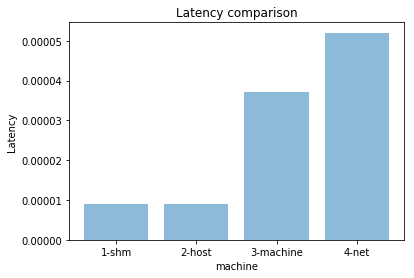

In [28]:
x = ('1-shm', '2-host', '3-machine', '4-net')
lts = [0.000009, 0.000009, 0.000037, 0.000052]
y_pos = np.arange(len(x))
 
plt.bar(y_pos, lts, align='center', alpha=0.5)
plt.xticks(y_pos, x)
plt.ylabel('Latency')
plt.xlabel('machine')
plt.title('Latency comparison')
 
plt.show()

## Podsumowanie

![title](results/5_mix.png)

* Wynik pomiaru *'2-host'* nie jest zogdny z przewidywaniami. Komunikacja przez pamięć powinna być szybsza.
* Najprawdopodobniej zmienna środowiskowa `MPIR_CVAR_CH3_NOLOCAL=1` wymuszające użycie komunikacji przez sieć nie działa dla implementacji MPI w Pythonie. Została ona wprowadzone w wersji ***3.0.4***
* Na vnode'ach jest wersja ***3.2***